In [89]:
import torch
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from skimage.transform import radon

In [38]:
# import matplotlib.pyplot as plt
# from skimage.data import shepp_logan_phantom
# from skimage.transform import radon,rescale,resize

# image = shepp_logan_phantom()
# image = resize(image, (28,28))
# ny,nx = image.shape

# plt.figure(figsize=(1,1))
# plt.imshow(image, cmap='gray')
# plt.show()

## Data from MNIST using torchvision.datasets

In [101]:
mnist_train_dataset = datasets.MNIST(root = './data', train = True, download = True)
mnist_test_dataset = datasets.MNIST(root = './data', train = False, download = True)
print(mnist_train_dataset.data.shape)

torch.Size([60000, 28, 28])


# Radon Matrix construction

In [20]:
# Radon Matrix exists for every angle and every line. matrix 
def getRadonMatrix(theta,ny,nx):
    colum_of_A = radon(np.zeros((ny,nx)), theta = theta) # this is only to know the size
    A = np.zeros((colum_of_A.size, nx*ny))
    for i in range(ny):
        for j in range(nx):
            basis_vec = np.zeros((ny,nx))
            basis_vec[i,j] = 1
            colum_of_A = radon(basis_vec, theta = theta)
            A[:,j+i*nx] = np.reshape(colum_of_A, colum_of_A.size)
    return A

In [40]:
# A = getRadonMatrix(theta,ny,nx)
# nr = 105
# plt.imshow(np.reshape(A[nr,:], (ny,nx)))
# plt.show()

In [104]:
nx, ny = 28, 28
## theta values for X ray incidence angles
theta = np.linspace(0,180,14,endpoint = True)
A = getRadonMatrix(theta, ny, nx)
print(A.shape)

C:\Users\asvp0\Anaconda3\envs\dl21\lib\site-packages\skimage\transform\radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


(392, 784)


##  Sinogram and Noisy Sinogram vectors

In [82]:
print(image.shape)
vec_img = np.reshape(image, A.shape[1])
print(vec_img.shape)
vec_sinogram = A@vec_img
print(vec_sinogram.shape)
noise_level = 0.01
vec_sinogram_noisy = vec_sinogram + noise_level*np.random.randn(vec_sinogram.size)
print(vec_sinogram_noisy.shape)

(28, 28)
(784,)
(784,)
(784,)


In [105]:
sinogram = radon(image, theta=theta)
print(sinogram.shape)

(28, 14)


C:\Users\asvp0\Anaconda3\envs\dl21\lib\site-packages\skimage\transform\radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


In [84]:
## how do we get vec_img from knowning vec_sinogram_noisy only?

# first idea: this is essentially - knowning y = Ax, how do I get x? 
#Why not just min_x ||Ax-y||^2 (and pick the x with minimal norm among all possible solutions)?
# 
pseudo_inverse_of_A = np.linalg.pinv(A)
reconstruction_noisy = pseudo_inverse_of_A@vec_sinogram_noisy   
reconstruction = pseudo_inverse_of_A@vec_sinogram
# computes the least squares (minimal norm) estimate as suggested above

## figure of (2,3) plottings in matplotlib

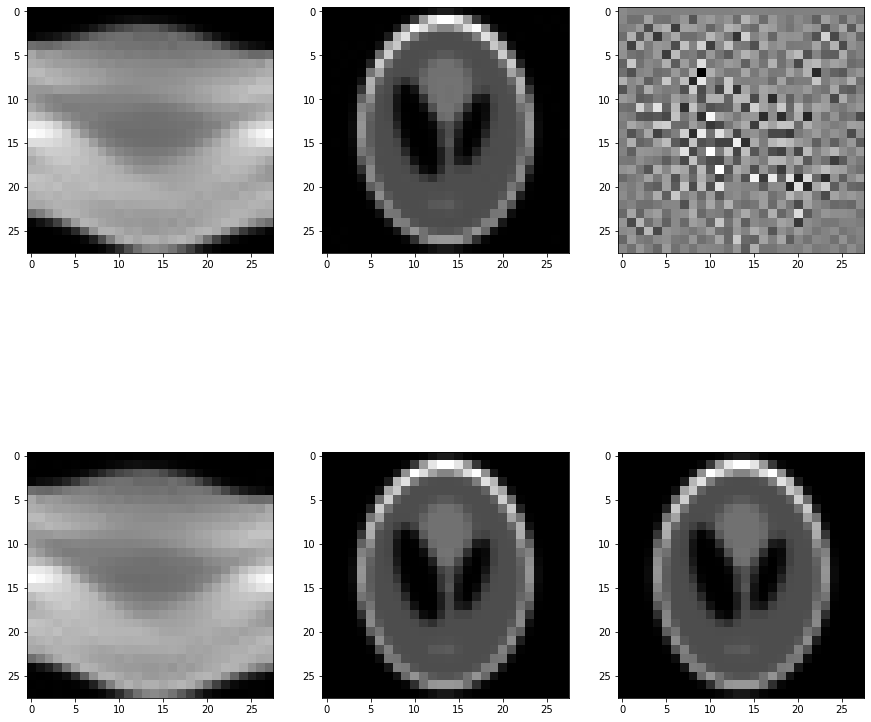

In [86]:
f, axis = plt.subplots(2, 3)
f.set_figheight(15)
f.set_figwidth(15)
axis[0,0].imshow(np.reshape(vec_sinogram, sinogram.shape), cmap='gray')
axis[1,0].imshow(np.reshape(vec_sinogram_noisy, sinogram.shape), cmap='gray')

axis[0,1].imshow(np.reshape(reconstruction, (ny,nx)), cmap='gray')
axis[1,1].imshow(image, cmap='gray')

axis[0,2].imshow(np.reshape(reconstruction_noisy, (ny,nx)), cmap='gray')
axis[1,2].imshow(image, cmap='gray')

plt.show()

## Neural Network Architecture

In [115]:
import torch
import torch.nn as nn
import torch.functional as F


class my_network(nn.Module):
    def __init__(self,dimension_of_sinogram , number_of_pixels):
        super(my_network,self).__init__()
        self.fc1 = nn.Linear(dimension_of_sinogram , number_of_pixels, bias=False)
        
        
    def forward(self, x):
        return self.fc1(x)

In [140]:
vec_image_data = torch.reshape(mnist_train_dataset.data, (mnist_train_dataset.data.shape[0],mnist_train_dataset.data.shape[1]*mnist_train_dataset.data.shape[2])).double()
print(vec_image_data.shape)
vec_sinogram_on_data = (vec_image_data @ A.T).double()
print(vec_sinogram_on_data.shape)
vec_sinogram_on_noisy_data = (vec_sinogram_on_data + noise_level*torch.randn(vec_sinogram_on_data.shape)) 
print(vec_sinogram_on_noisy_data.shape)

torch.Size([60000, 784])
torch.Size([60000, 392])
torch.Size([60000, 392])


In [141]:
print(vec_image_data.dtype)
print(vec_sinogram_on_data.dtype)
print(vec_sinogram_on_noisy_data.dtype)
# input_data = torch.from_numpy(vec_sinogram_noisy).float()[None,:]
# print(input_data.shape)
# desired_output = torch.from_numpy(vec_img).float()[None,:]

torch.float64
torch.float64
torch.float64


## Loading or sending data to model using Dataloader

In [221]:
train_loader = DataLoader((vec_sinogram_on_noisy_data, vec_image_data), batch_size=10, shuffle=True, drop_last=True)
# test_loader = DataLoader(, batch_size=10, shuffle=True, drop_last=True)

## setting neural network along with the loss and Adam optimizer(gradient descent) 

In [198]:
model = my_network(A.shape[0],  A.shape[1])
criterion = nn.MSELoss()
# gradient descent - torch.optim.Adam
# stochastic gradient descent - torch.optim.SGD
optim = torch.optim.Adam(model.parameters(), lr=0.001)
model = model.double()

## Running model using Dataloader

In [224]:
number_of_epochs = 10
#for epoch in range(number_of_epochs):
#for i,(x_train,y_train) in enumerate(train_loader): 
#    print(i)
#         network_input, desired_output = data
#         print(data.shape)
#         prediction = model(network_input)
#         print(prediction.shape)
#         loss = criterion(prediction, desired_output)

#         print(epoch)
#         optim.zero_grad()
#         loss.backward()
#         optim.step()
    

StopIteration: 

In [145]:
# reconstruction = model(input_data).detach().numpy()

# f, axis = plt.subplots(2, 2)
# f.set_figheight(15)
# f.set_figwidth(15)
# axis[0,0].imshow(np.reshape(vec_sinogram, sinogram.shape), cmap='gray')
# axis[0,1].imshow(np.reshape(input_data.detach().numpy(),  sinogram.shape), cmap='gray')


# axis[1,0].imshow(np.reshape(reconstruction, (ny,nx)), cmap='gray')
# axis[1,1].imshow(image, cmap='gray')
# plt.show()